# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.0193
Epoch 1/200, Iteration 2/12, Loss: 0.4232
Epoch 1/200, Iteration 3/12, Loss: 1.0417
Epoch 1/200, Iteration 4/12, Loss: 0.1587
Epoch 1/200, Iteration 5/12, Loss: 0.3044
Epoch 1/200, Iteration 6/12, Loss: 0.4486
Epoch 1/200, Iteration 7/12, Loss: 0.3680
Epoch 1/200, Iteration 8/12, Loss: 0.3125
Epoch 1/200, Iteration 9/12, Loss: 0.1459
Epoch 1/200, Iteration 10/12, Loss: 0.1308
Epoch 1/200, Iteration 11/12, Loss: 0.1306
Epoch 1/200, Iteration 12/12, Loss: 0.1031
Epoch 1/200, Iteration 13/12, Loss: 0.1139
Train Error: 
 Accuracy: 77.88%, Avg loss: 0.067237, MRE: 0.177171, MAE: 0.026311 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.067703, MRE: 0.147845, MAE: 0.027719 

Epoch 2/200, Iteration 1/12, Loss: 0.0724
Epoch 2/200, Iteration 2/12, Loss: 0.0718
Epoch 2/200, Iteration 3/12, Loss: 0.0745
Epoch 2/200, Iteration 4/12, Loss: 0.0699
Epoch 2/200, Iteration 5/12, Loss: 0.0775
Epoch 2/200, Iteration 6/12, Loss: 0.0782
Epoch 2/200, Iteration 7/12, Los

Epoch 12/200, Iteration 8/12, Loss: 0.0036
Epoch 12/200, Iteration 9/12, Loss: 0.0029
Epoch 12/200, Iteration 10/12, Loss: 0.0021
Epoch 12/200, Iteration 11/12, Loss: 0.0026
Epoch 12/200, Iteration 12/12, Loss: 0.0023
Epoch 12/200, Iteration 13/12, Loss: 0.0073
Train Error: 
 Accuracy: 63.75%, Avg loss: 0.011086, MRE: 0.043271, MAE: 0.007462 

Test Error: 
 Accuracy: 64.5%, Avg loss: 0.008989, MRE: 0.036265, MAE: 0.006563 

Epoch 13/200, Iteration 1/12, Loss: 0.0110
Epoch 13/200, Iteration 2/12, Loss: 0.0056
Epoch 13/200, Iteration 3/12, Loss: 0.0136
Epoch 13/200, Iteration 4/12, Loss: 0.0052
Epoch 13/200, Iteration 5/12, Loss: 0.0132
Epoch 13/200, Iteration 6/12, Loss: 0.0041
Epoch 13/200, Iteration 7/12, Loss: 0.0050
Epoch 13/200, Iteration 8/12, Loss: 0.0109
Epoch 13/200, Iteration 9/12, Loss: 0.0062
Epoch 13/200, Iteration 10/12, Loss: 0.0083
Epoch 13/200, Iteration 11/12, Loss: 0.0038
Epoch 13/200, Iteration 12/12, Loss: 0.0046
Epoch 13/200, Iteration 13/12, Loss: 0.0043
Train Err

Train Error: 
 Accuracy: 90.5%, Avg loss: 0.004465, MRE: 0.039109, MAE: 0.006876 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.003966, MRE: 0.035655, MAE: 0.006639 

Epoch 24/200, Iteration 1/12, Loss: 0.0054
Epoch 24/200, Iteration 2/12, Loss: 0.0036
Epoch 24/200, Iteration 3/12, Loss: 0.0077
Epoch 24/200, Iteration 4/12, Loss: 0.0045
Epoch 24/200, Iteration 5/12, Loss: 0.0066
Epoch 24/200, Iteration 6/12, Loss: 0.0039
Epoch 24/200, Iteration 7/12, Loss: 0.0037
Epoch 24/200, Iteration 8/12, Loss: 0.0049
Epoch 24/200, Iteration 9/12, Loss: 0.0052
Epoch 24/200, Iteration 10/12, Loss: 0.0019
Epoch 24/200, Iteration 11/12, Loss: 0.0035
Epoch 24/200, Iteration 12/12, Loss: 0.0030
Epoch 24/200, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.003185, MRE: 0.027140, MAE: 0.005842 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003465, MRE: 0.028503, MAE: 0.006321 

Epoch 25/200, Iteration 1/12, Loss: 0.0035
Epoch 25/200, Iteration 2/12, Loss: 0.0021
Epoch 25/200, Iterat

Epoch 35/200, Iteration 8/12, Loss: 0.0004
Epoch 35/200, Iteration 9/12, Loss: 0.0002
Epoch 35/200, Iteration 10/12, Loss: 0.0004
Epoch 35/200, Iteration 11/12, Loss: 0.0002
Epoch 35/200, Iteration 12/12, Loss: 0.0002
Epoch 35/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000210, MRE: 0.008535, MAE: 0.001381 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007746, MAE: 0.001531 

Epoch 36/200, Iteration 1/12, Loss: 0.0002
Epoch 36/200, Iteration 2/12, Loss: 0.0002
Epoch 36/200, Iteration 3/12, Loss: 0.0002
Epoch 36/200, Iteration 4/12, Loss: 0.0002
Epoch 36/200, Iteration 5/12, Loss: 0.0002
Epoch 36/200, Iteration 6/12, Loss: 0.0002
Epoch 36/200, Iteration 7/12, Loss: 0.0001
Epoch 36/200, Iteration 8/12, Loss: 0.0001
Epoch 36/200, Iteration 9/12, Loss: 0.0001
Epoch 36/200, Iteration 10/12, Loss: 0.0003
Epoch 36/200, Iteration 11/12, Loss: 0.0002
Epoch 36/200, Iteration 12/12, Loss: 0.0001
Epoch 36/200, Iteration 13/12, Loss: 0.0004
Train Er

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000087, MRE: 0.006239, MAE: 0.000874 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000095, MRE: 0.004747, MAE: 0.000970 

Epoch 47/200, Iteration 1/12, Loss: 0.0001
Epoch 47/200, Iteration 2/12, Loss: 0.0001
Epoch 47/200, Iteration 3/12, Loss: 0.0001
Epoch 47/200, Iteration 4/12, Loss: 0.0001
Epoch 47/200, Iteration 5/12, Loss: 0.0001
Epoch 47/200, Iteration 6/12, Loss: 0.0001
Epoch 47/200, Iteration 7/12, Loss: 0.0001
Epoch 47/200, Iteration 8/12, Loss: 0.0001
Epoch 47/200, Iteration 9/12, Loss: 0.0001
Epoch 47/200, Iteration 10/12, Loss: 0.0001
Epoch 47/200, Iteration 11/12, Loss: 0.0001
Epoch 47/200, Iteration 12/12, Loss: 0.0001
Epoch 47/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000080, MRE: 0.006009, MAE: 0.000861 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000088, MRE: 0.004606, MAE: 0.000946 

Epoch 48/200, Iteration 1/12, Loss: 0.0001
Epoch 48/200, Iteration 2/12, Loss: 0.0001
Epoch 48/200, Ite

Epoch 58/200, Iteration 8/12, Loss: 0.0001
Epoch 58/200, Iteration 9/12, Loss: 0.0000
Epoch 58/200, Iteration 10/12, Loss: 0.0001
Epoch 58/200, Iteration 11/12, Loss: 0.0001
Epoch 58/200, Iteration 12/12, Loss: 0.0001
Epoch 58/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000071, MRE: 0.007474, MAE: 0.000789 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000081, MRE: 0.004486, MAE: 0.000890 

Epoch 59/200, Iteration 1/12, Loss: 0.0001
Epoch 59/200, Iteration 2/12, Loss: 0.0001
Epoch 59/200, Iteration 3/12, Loss: 0.0001
Epoch 59/200, Iteration 4/12, Loss: 0.0001
Epoch 59/200, Iteration 5/12, Loss: 0.0001
Epoch 59/200, Iteration 6/12, Loss: 0.0001
Epoch 59/200, Iteration 7/12, Loss: 0.0001
Epoch 59/200, Iteration 8/12, Loss: 0.0001
Epoch 59/200, Iteration 9/12, Loss: 0.0001
Epoch 59/200, Iteration 10/12, Loss: 0.0001
Epoch 59/200, Iteration 11/12, Loss: 0.0000
Epoch 59/200, Iteration 12/12, Loss: 0.0001
Epoch 59/200, Iteration 13/12, Loss: 0.0000
Train Er

Epoch 69/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000053, MRE: 0.005279, MAE: 0.000702 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000060, MRE: 0.003981, MAE: 0.000783 

Epoch 70/200, Iteration 1/12, Loss: 0.0001
Epoch 70/200, Iteration 2/12, Loss: 0.0001
Epoch 70/200, Iteration 3/12, Loss: 0.0001
Epoch 70/200, Iteration 4/12, Loss: 0.0001
Epoch 70/200, Iteration 5/12, Loss: 0.0001
Epoch 70/200, Iteration 6/12, Loss: 0.0000
Epoch 70/200, Iteration 7/12, Loss: 0.0001
Epoch 70/200, Iteration 8/12, Loss: 0.0000
Epoch 70/200, Iteration 9/12, Loss: 0.0001
Epoch 70/200, Iteration 10/12, Loss: 0.0001
Epoch 70/200, Iteration 11/12, Loss: 0.0000
Epoch 70/200, Iteration 12/12, Loss: 0.0001
Epoch 70/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.005222, MAE: 0.000686 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000060, MRE: 0.003939, MAE: 0.000773 

Epoch 71/200, Iteration 1/12, Loss: 0.0000
Epoch 71/200, It

Epoch 81/200, Iteration 10/12, Loss: 0.0001
Epoch 81/200, Iteration 11/12, Loss: 0.0001
Epoch 81/200, Iteration 12/12, Loss: 0.0000
Epoch 81/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.005050, MAE: 0.000650 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000056, MRE: 0.003865, MAE: 0.000758 

Epoch 82/200, Iteration 1/12, Loss: 0.0000
Epoch 82/200, Iteration 2/12, Loss: 0.0000
Epoch 82/200, Iteration 3/12, Loss: 0.0001
Epoch 82/200, Iteration 4/12, Loss: 0.0001
Epoch 82/200, Iteration 5/12, Loss: 0.0001
Epoch 82/200, Iteration 6/12, Loss: 0.0000
Epoch 82/200, Iteration 7/12, Loss: 0.0000
Epoch 82/200, Iteration 8/12, Loss: 0.0000
Epoch 82/200, Iteration 9/12, Loss: 0.0000
Epoch 82/200, Iteration 10/12, Loss: 0.0001
Epoch 82/200, Iteration 11/12, Loss: 0.0000
Epoch 82/200, Iteration 12/12, Loss: 0.0000
Epoch 82/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.005034, MAE: 0.000652 

Test Error

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000056, MRE: 0.005403, MAE: 0.000727 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000059, MRE: 0.003946, MAE: 0.000788 

Epoch 93/200, Iteration 1/12, Loss: 0.0001
Epoch 93/200, Iteration 2/12, Loss: 0.0000
Epoch 93/200, Iteration 3/12, Loss: 0.0001
Epoch 93/200, Iteration 4/12, Loss: 0.0000
Epoch 93/200, Iteration 5/12, Loss: 0.0001
Epoch 93/200, Iteration 6/12, Loss: 0.0001
Epoch 93/200, Iteration 7/12, Loss: 0.0001
Epoch 93/200, Iteration 8/12, Loss: 0.0001
Epoch 93/200, Iteration 9/12, Loss: 0.0001
Epoch 93/200, Iteration 10/12, Loss: 0.0000
Epoch 93/200, Iteration 11/12, Loss: 0.0001
Epoch 93/200, Iteration 12/12, Loss: 0.0001
Epoch 93/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000045, MRE: 0.005195, MAE: 0.000650 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000054, MRE: 0.003771, MAE: 0.000745 

Epoch 94/200, Iteration 1/12, Loss: 0.0001
Epoch 94/200, Iteration 2/12, Loss: 0.0000
Epoch 94/200, Ite

Epoch 104/200, Iteration 9/12, Loss: 0.0000
Epoch 104/200, Iteration 10/12, Loss: 0.0000
Epoch 104/200, Iteration 11/12, Loss: 0.0000
Epoch 104/200, Iteration 12/12, Loss: 0.0000
Epoch 104/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000043, MRE: 0.005014, MAE: 0.000611 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000048, MRE: 0.003294, MAE: 0.000658 

Epoch 105/200, Iteration 1/12, Loss: 0.0000
Epoch 105/200, Iteration 2/12, Loss: 0.0001
Epoch 105/200, Iteration 3/12, Loss: 0.0000
Epoch 105/200, Iteration 4/12, Loss: 0.0001
Epoch 105/200, Iteration 5/12, Loss: 0.0001
Epoch 105/200, Iteration 6/12, Loss: 0.0000
Epoch 105/200, Iteration 7/12, Loss: 0.0000
Epoch 105/200, Iteration 8/12, Loss: 0.0000
Epoch 105/200, Iteration 9/12, Loss: 0.0001
Epoch 105/200, Iteration 10/12, Loss: 0.0000
Epoch 105/200, Iteration 11/12, Loss: 0.0000
Epoch 105/200, Iteration 12/12, Loss: 0.0000
Epoch 105/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, 

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000038, MRE: 0.004554, MAE: 0.000577 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000041, MRE: 0.003382, MAE: 0.000649 

Epoch 116/200, Iteration 1/12, Loss: 0.0000
Epoch 116/200, Iteration 2/12, Loss: 0.0000
Epoch 116/200, Iteration 3/12, Loss: 0.0000
Epoch 116/200, Iteration 4/12, Loss: 0.0000
Epoch 116/200, Iteration 5/12, Loss: 0.0000
Epoch 116/200, Iteration 6/12, Loss: 0.0001
Epoch 116/200, Iteration 7/12, Loss: 0.0001
Epoch 116/200, Iteration 8/12, Loss: 0.0000
Epoch 116/200, Iteration 9/12, Loss: 0.0000
Epoch 116/200, Iteration 10/12, Loss: 0.0000
Epoch 116/200, Iteration 11/12, Loss: 0.0000
Epoch 116/200, Iteration 12/12, Loss: 0.0001
Epoch 116/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000034, MRE: 0.004689, MAE: 0.000548 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000042, MRE: 0.003245, MAE: 0.000620 

Epoch 117/200, Iteration 1/12, Loss: 0.0000
Epoch 117/200, Iteration 2/12, Loss: 0.0000
Ep

Epoch 127/200, Iteration 11/12, Loss: 0.0000
Epoch 127/200, Iteration 12/12, Loss: 0.0000
Epoch 127/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000030, MRE: 0.004328, MAE: 0.000520 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000040, MRE: 0.003059, MAE: 0.000611 

Epoch 128/200, Iteration 1/12, Loss: 0.0000
Epoch 128/200, Iteration 2/12, Loss: 0.0000
Epoch 128/200, Iteration 3/12, Loss: 0.0000
Epoch 128/200, Iteration 4/12, Loss: 0.0000
Epoch 128/200, Iteration 5/12, Loss: 0.0000
Epoch 128/200, Iteration 6/12, Loss: 0.0001
Epoch 128/200, Iteration 7/12, Loss: 0.0000
Epoch 128/200, Iteration 8/12, Loss: 0.0000
Epoch 128/200, Iteration 9/12, Loss: 0.0000
Epoch 128/200, Iteration 10/12, Loss: 0.0000
Epoch 128/200, Iteration 11/12, Loss: 0.0000
Epoch 128/200, Iteration 12/12, Loss: 0.0000
Epoch 128/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000030, MRE: 0.004401, MAE: 0.000532 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.004094, MAE: 0.000463 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000033, MRE: 0.002816, MAE: 0.000560 

Epoch 139/200, Iteration 1/12, Loss: 0.0000
Epoch 139/200, Iteration 2/12, Loss: 0.0000
Epoch 139/200, Iteration 3/12, Loss: 0.0000
Epoch 139/200, Iteration 4/12, Loss: 0.0000
Epoch 139/200, Iteration 5/12, Loss: 0.0000
Epoch 139/200, Iteration 6/12, Loss: 0.0000
Epoch 139/200, Iteration 7/12, Loss: 0.0000
Epoch 139/200, Iteration 8/12, Loss: 0.0000
Epoch 139/200, Iteration 9/12, Loss: 0.0000
Epoch 139/200, Iteration 10/12, Loss: 0.0000
Epoch 139/200, Iteration 11/12, Loss: 0.0000
Epoch 139/200, Iteration 12/12, Loss: 0.0000
Epoch 139/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.004095, MAE: 0.000465 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000032, MRE: 0.002808, MAE: 0.000550 

Epoch 140/200, Iteration 1/12, Loss: 0.0000
Epoch 140/200, Iteration 2/12, Loss: 0.0000
Ep

Epoch 150/200, Iteration 10/12, Loss: 0.0000
Epoch 150/200, Iteration 11/12, Loss: 0.0000
Epoch 150/200, Iteration 12/12, Loss: 0.0000
Epoch 150/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004060, MAE: 0.000453 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000032, MRE: 0.002763, MAE: 0.000545 

Epoch 151/200, Iteration 1/12, Loss: 0.0000
Epoch 151/200, Iteration 2/12, Loss: 0.0000
Epoch 151/200, Iteration 3/12, Loss: 0.0000
Epoch 151/200, Iteration 4/12, Loss: 0.0000
Epoch 151/200, Iteration 5/12, Loss: 0.0001
Epoch 151/200, Iteration 6/12, Loss: 0.0000
Epoch 151/200, Iteration 7/12, Loss: 0.0000
Epoch 151/200, Iteration 8/12, Loss: 0.0000
Epoch 151/200, Iteration 9/12, Loss: 0.0000
Epoch 151/200, Iteration 10/12, Loss: 0.0000
Epoch 151/200, Iteration 11/12, Loss: 0.0000
Epoch 151/200, Iteration 12/12, Loss: 0.0000
Epoch 151/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004043, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004024, MAE: 0.000453 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.002719, MAE: 0.000539 

Epoch 162/200, Iteration 1/12, Loss: 0.0000
Epoch 162/200, Iteration 2/12, Loss: 0.0000
Epoch 162/200, Iteration 3/12, Loss: 0.0000
Epoch 162/200, Iteration 4/12, Loss: 0.0000
Epoch 162/200, Iteration 5/12, Loss: 0.0000
Epoch 162/200, Iteration 6/12, Loss: 0.0000
Epoch 162/200, Iteration 7/12, Loss: 0.0000
Epoch 162/200, Iteration 8/12, Loss: 0.0000
Epoch 162/200, Iteration 9/12, Loss: 0.0000
Epoch 162/200, Iteration 10/12, Loss: 0.0000
Epoch 162/200, Iteration 11/12, Loss: 0.0000
Epoch 162/200, Iteration 12/12, Loss: 0.0000
Epoch 162/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004074, MAE: 0.000450 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.002712, MAE: 0.000539 

Epoch 163/200, Iteration 1/12, Loss: 0.0000
Epoch 163/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004030, MAE: 0.000448 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.002705, MAE: 0.000539 

Epoch 174/200, Iteration 1/12, Loss: 0.0000
Epoch 174/200, Iteration 2/12, Loss: 0.0000
Epoch 174/200, Iteration 3/12, Loss: 0.0000
Epoch 174/200, Iteration 4/12, Loss: 0.0000
Epoch 174/200, Iteration 5/12, Loss: 0.0000
Epoch 174/200, Iteration 6/12, Loss: 0.0000
Epoch 174/200, Iteration 7/12, Loss: 0.0000
Epoch 174/200, Iteration 8/12, Loss: 0.0000
Epoch 174/200, Iteration 9/12, Loss: 0.0000
Epoch 174/200, Iteration 10/12, Loss: 0.0000
Epoch 174/200, Iteration 11/12, Loss: 0.0000
Epoch 174/200, Iteration 12/12, Loss: 0.0000
Epoch 174/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004022, MAE: 0.000446 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.002727, MAE: 0.000537 

Epoch 175/200, Iteration 1/12, Loss: 0.0000
Epoch 175/200, Iteration 2/12, Loss: 0.0000
Ep

Epoch 185/200, Iteration 10/12, Loss: 0.0000
Epoch 185/200, Iteration 11/12, Loss: 0.0000
Epoch 185/200, Iteration 12/12, Loss: 0.0000
Epoch 185/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000022, MRE: 0.004025, MAE: 0.000442 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.002667, MAE: 0.000531 

Epoch 186/200, Iteration 1/12, Loss: 0.0000
Epoch 186/200, Iteration 2/12, Loss: 0.0000
Epoch 186/200, Iteration 3/12, Loss: 0.0000
Epoch 186/200, Iteration 4/12, Loss: 0.0000
Epoch 186/200, Iteration 5/12, Loss: 0.0000
Epoch 186/200, Iteration 6/12, Loss: 0.0000
Epoch 186/200, Iteration 7/12, Loss: 0.0000
Epoch 186/200, Iteration 8/12, Loss: 0.0000
Epoch 186/200, Iteration 9/12, Loss: 0.0000
Epoch 186/200, Iteration 10/12, Loss: 0.0000
Epoch 186/200, Iteration 11/12, Loss: 0.0000
Epoch 186/200, Iteration 12/12, Loss: 0.0000
Epoch 186/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000022, MRE: 0.003999, MAE: 0.00

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000022, MRE: 0.004002, MAE: 0.000438 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000030, MRE: 0.002650, MAE: 0.000525 

Epoch 197/200, Iteration 1/12, Loss: 0.0000
Epoch 197/200, Iteration 2/12, Loss: 0.0000
Epoch 197/200, Iteration 3/12, Loss: 0.0000
Epoch 197/200, Iteration 4/12, Loss: 0.0000
Epoch 197/200, Iteration 5/12, Loss: 0.0000
Epoch 197/200, Iteration 6/12, Loss: 0.0000
Epoch 197/200, Iteration 7/12, Loss: 0.0000
Epoch 197/200, Iteration 8/12, Loss: 0.0000
Epoch 197/200, Iteration 9/12, Loss: 0.0000
Epoch 197/200, Iteration 10/12, Loss: 0.0000
Epoch 197/200, Iteration 11/12, Loss: 0.0000
Epoch 197/200, Iteration 12/12, Loss: 0.0000
Epoch 197/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.005573, MAE: 0.000445 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000030, MRE: 0.002673, MAE: 0.000525 

Epoch 198/200, Iteration 1/12, Loss: 0.0000
Epoch 198/200, Iteration 2/12, Loss: 0.0000
Ep

#### Plots loss vs Epoch

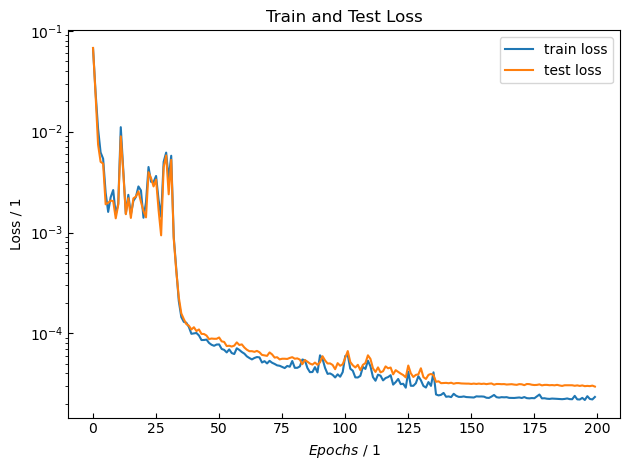

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999815002691304 , R^2(NH3) = 0.9999739097942599
Test Dataset: R^2(H2) = 0.9999689948672242 , R^2(NH3) = 0.9999700198540906
Max Error Training: |x_H2 - x_H2,pred| = 0.008563017311323196 , |x_NH3 - x_NH3,pred| = 0.003030577609750895
Max Error Test: |x_H2 - x_H2,pred| = 0.004330851896324317 , |x_NH3 - x_NH3,pred| = 0.003262300160102455


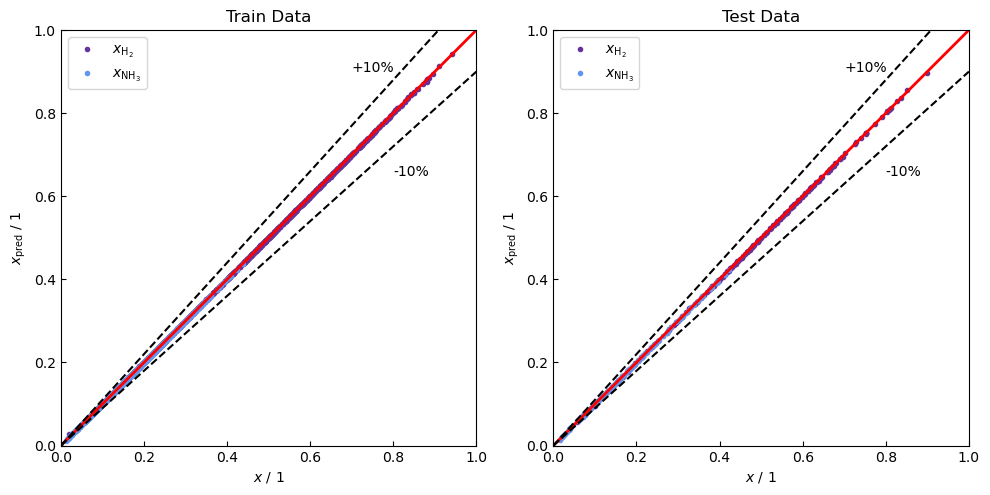

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

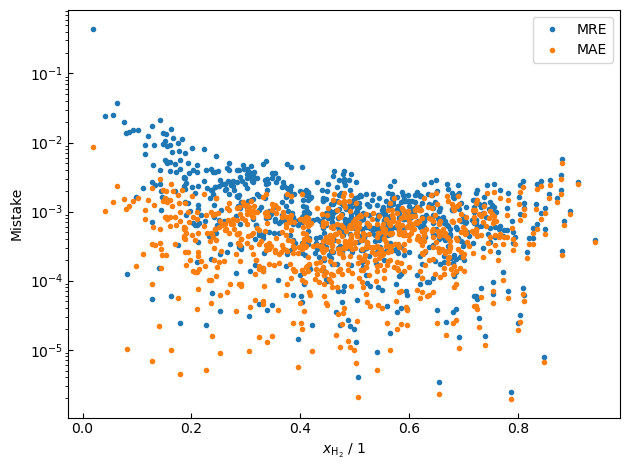

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

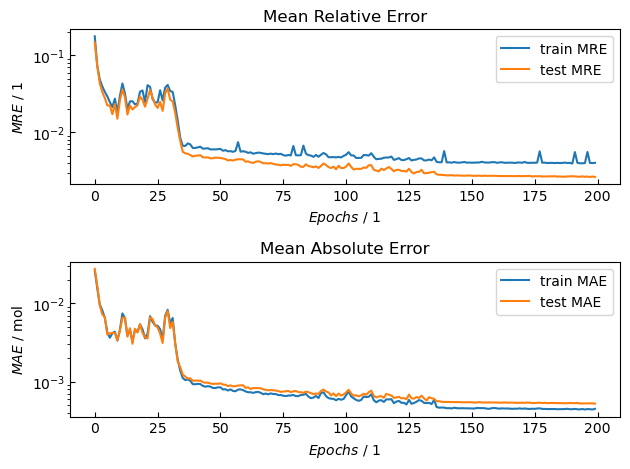

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

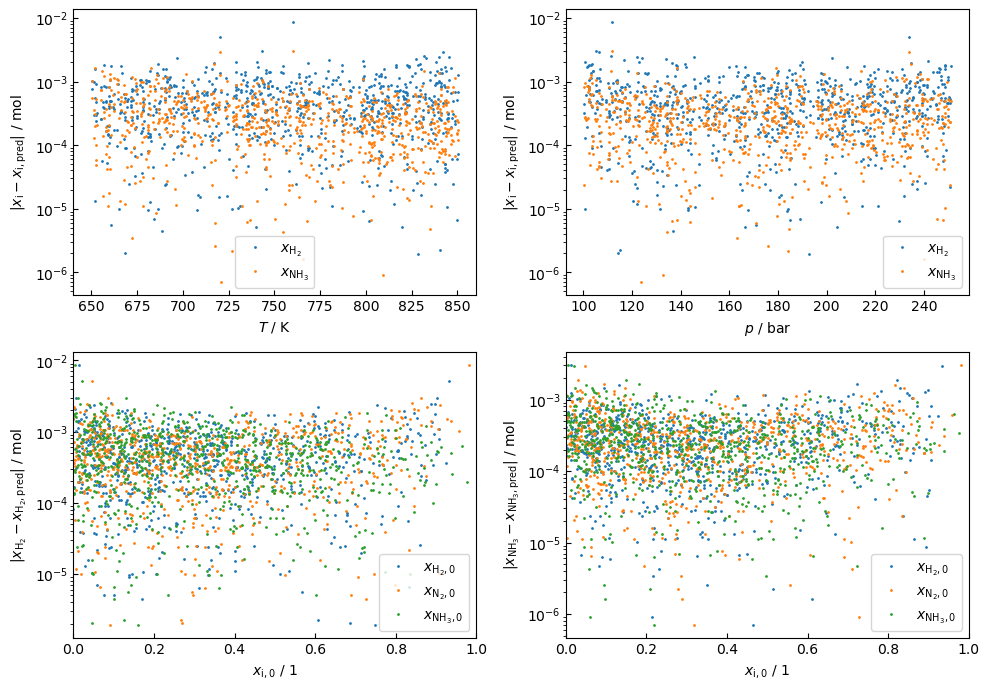

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

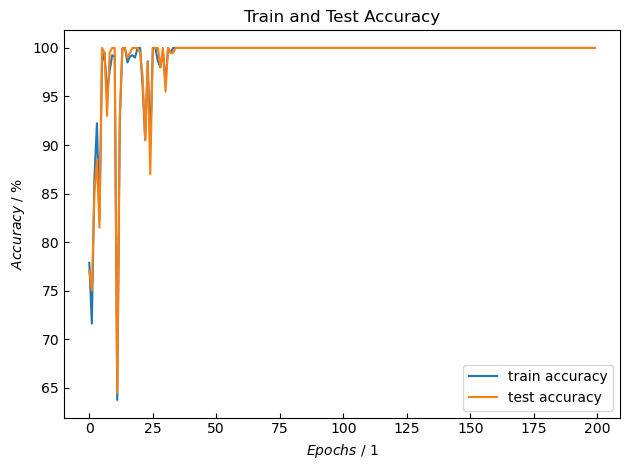

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.140625 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.7501, -1.1972,  0.4082, -0.8752,  0.4939],
        [-1.7006,  0.5709, -0.9870,  1.1048, -0.1606],
        [-0.9565, -0.5200, -0.5875,  1.4133, -0.8679],
        [ 0.5004, -0.7904,  0.0680,  0.0222, -0.0894],
        [ 1.3538, -0.2770,  0.4574,  0.3898, -0.8474],
        [ 1.1453, -1.0705, -0.3256,  1.2234, -0.9309],
        [-1.0007,  0.6070, -1.2187,  2.3841, -1.2407],
        [ 1.1900,  0.7035, -0.0235, -1.0976,  1.1448],
        [ 1.1156,  0.3455,  0.1973, -1.1805,  1.0130],
        [ 0.7875,  0.8012,  0.8098,  0.0512, -0.8470],
        [ 0.1285, -1.3181, -0.8661, -0.9336,  1.8042],
        [ 0.2214,  0.9939, -1.0644,  2.1124, -1.1144],
        [-1.5485,  0.2679,  2.2703, -1.2167, -0.9844],
        [-1.5794, -1.6658, -0.3355,  1.6491, -1.3562],
        [ 0.1620, -1.6405, -0.8078, -0.1721,  0.9686],
        [-1.7629,  0.8627,  0.4274,  0.9475, -1.3879],
        [-0.5127,  0.9019,  0.1235, -0.1435,  0.0255],
        [-0.6383,  0.0080,  0.0749,  0.9148, -1.0085],
        [-

#### Einblick in Netzwerk

In [19]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 1.5471e-01, -1.2722e-01,  1.6706e-01, -4.2730e-01, -5.5484e-02],
         [-3.6365e-01, -5.2404e-02, -1.2790e-01, -2.2051e-01, -1.5747e-01],
         [ 3.1361e-01,  5.1717e-02,  1.2017e-01, -2.2447e-01,  4.3409e-02],
         [-9.8782e-02, -1.7308e-01, -2.6100e-02, -1.6299e-01,  1.1194e-01],
         [-2.1241e-01,  2.4420e-01,  2.2613e-01,  1.9303e-01, -2.5580e-01],
         [ 6.4194e-02,  1.6710e-02,  3.1438e-01,  4.4169e-01, -1.8690e-02],
         [-1.9819e-01, -6.1497e-02,  5.2080e-03, -3.1522e-02,  1.7629e-01],
         [ 2.4191e-01,  1.9639e-01,  3.2614e-01,  3.9134e-01,  2.0896e-01],
         [ 2.5379e-01, -1.7050e-01,  1.4608e-01, -3.4103e-01,  2.6482e-01],
         [-3.7373e-02, -1.0529e-01,  3.4986e-01,  3.1788e-01,  3.8100e-01],
         [-2.1554e-01,  2.3012e-01,  2.8078e-01, -3.8741e-01, -5.8210e-02],
         [-1.1320e-03,  2.0140e-01, -3.3560e-01,  3.4468e-01, -4.0077e-01],
         [ 5.7576e-02,  1.3650e-01, -1.8849e-01,  3.0632e-01,  2.

In [20]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6036, 0.3907, 0.8503, 0.0464, 0.2424],
        [0.5511, 0.0175, 0.6919, 0.3529, 0.7380]])
tensor([[ 0.4927, -0.1772],
        [ 0.3764, -0.3151]], grad_fn=<AddmmBackward0>)


In [21]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [22]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 3.2600e-01,  6.2154e-01,  2.3266e+00, -1.3453e+00, -9.0828e-01],
        [-1.2218e+00,  3.9974e-01, -1.1886e-01, -8.2186e-01,  9.5665e-01],
        [-1.0013e+00, -1.1647e+00, -7.8956e-01,  1.8161e+00, -1.0813e+00],
        [ 7.9296e-01, -9.7393e-01, -1.0534e+00, -5.7799e-01,  1.6245e+00],
        [-2.0754e-01, -1.6050e+00, -1.4096e+00,  2.1889e+00, -8.5389e-01],
        [ 8.2211e-01,  4.9447e-02,  8.8542e-01,  3.8255e-01, -1.2599e+00],
        [-1.0546e+00, -1.1501e+00,  2.1388e+00, -9.5560e-01, -1.1223e+00],
        [-1.6716e+00,  3.0497e-01,  2.2128e+00, -1.0556e+00, -1.0926e+00],
        [ 2.3369e-01,  5.3065e-01, -5.6861e-01,  1.6161e+00, -1.0938e+00],
        [ 2.1431e-01, -8.9262e-01, -3.7919e-02, -1.1237e+00,  1.1857e+00],
        [-7.9972e-01, -1.0352e+00, -2.5068e-01, -1.3865e-01,  3.8772e-01],
        [ 1.4930e+00, -5.7002e-01, -4.0104e-01,  3.4526e-02,  3.5829e-01],
        [-1.6531e+00,  1.8502e-01,  9.0039e-01, -1.2272e+00,  3.7061e-01],
        [-1.7403e+00, -2.

tensor([[ 9.4424e-02,  3.2336e-01,  1.6442e+00, -1.2003e+00, -8.6171e-01],
        [-1.3410e+00,  7.0929e-01,  5.3566e-02, -8.3534e-01,  1.4135e+00],
        [-4.9005e-01, -6.3371e-01, -3.0379e-01,  1.9879e+00, -5.6038e-01],
        [ 7.8109e-01, -8.8063e-01, -9.5533e-01, -5.0826e-01,  1.5631e+00],
        [ 1.2380e-01, -8.9462e-01, -7.5221e-01,  1.8703e+00, -3.4724e-01],
        [ 8.2854e-01, -1.6216e-01,  9.0971e-01,  2.6494e-01, -1.8410e+00],
        [-4.8681e-01, -5.6112e-01,  1.9973e+00, -4.0983e-01, -5.3950e-01],
        [-1.0104e+00,  4.0483e-01,  1.7708e+00, -5.6939e-01, -5.9587e-01],
        [ 9.6408e-02,  4.1425e-01, -7.6231e-01,  1.5760e+00, -1.3244e+00],
        [ 4.1690e-01, -9.2012e-01,  1.1224e-01, -1.1992e+00,  1.5902e+00],
        [-8.5830e-01, -1.3257e+00,  2.3150e-01,  4.5387e-01,  1.4987e+00],
        [ 1.7904e+00, -1.0290e+00, -7.9811e-01, -2.0285e-01,  2.3961e-01],
        [-1.3943e+00,  4.7880e-01,  1.2077e+00, -9.6019e-01,  6.6791e-01],
        [-1.3713e+00,  1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

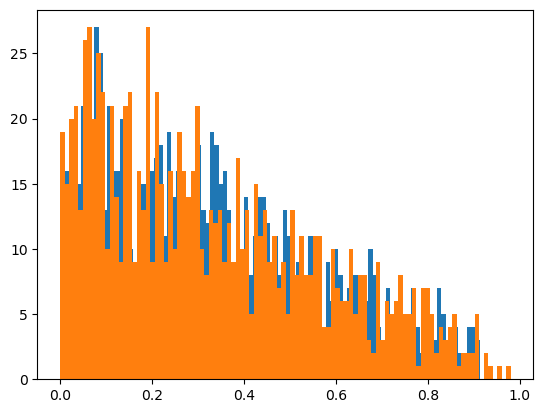

In [23]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [25]:
torch.save(net.state_dict(),'data/models/ann_005_020.pth')
np.savez('data/models/params_005_020.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)